In [1]:
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.optimize import minimize
stops = set(stopwords.words("english"))
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import multiprocessing
import difflib

/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
features = [
    'clean_q1_lemmatized',
    'clean_q2_lemmatized',
    'clean_q1_lemmatized_stem',
    'clean_q2_lemmatized_stem'
]

In [3]:
def read_data(t, features):
    data = pd.read_csv('../input/{}.csv'.format(t))
    for feature in features:
        data = pd.merge(data, pd.read_pickle('../feature/{}_{}.pkl'.format(t, feature)))
    data.fillna(0.0)
    return data

In [4]:
train = read_data('train', features)#[:1000]
test = read_data('test', features)#[:1000]

In [5]:
from multiprocessing import Pool

In [6]:
def parallel(df, func):
    splitted_df = np.array_split(df, 6)
    pool = Pool(6)
    df = pd.concat(pool.map(func, splitted_df))
    pool.close()
    pool.join()
    return df

In [7]:
def bleu(a, b):
    return nltk.translate.bleu_score.sentence_bleu([a], b)

params = (
    ('clean_q1_lemmatized_stem', 'clean_q2_lemmatized_stem', 'bleu_clean_lemm_stem_q1q2'),
    ('clean_q2_lemmatized_stem', 'clean_q1_lemmatized_stem', 'bleu_clean_lemm_stem_q2q1'),
    ('clean_q1_lemmatized', 'clean_q2_lemmatized', 'bleu_clean_lemm_q1q2'),
    ('clean_q2_lemmatized', 'clean_q1_lemmatized', 'bleu_clean_lemm_q2q1'),
)

def add_bleu(df):
    for param in params:
        df[param[2]] = df.apply(lambda row: bleu(row[param[0]], row[param[1]]), axis=1)
    return df

In [8]:
train = add_bleu(train)

/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/nltk/translate/bleu_score.py:472: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/nltk/translate/bleu_score.py:472: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/nltk/translate/bleu_score.py:472: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [9]:
test = add_bleu(test)

/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/nltk/translate/bleu_score.py:472: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/nltk/translate/bleu_score.py:472: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/nltk/translate/bleu_score.py:472: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [10]:
features_to_save = [
    'bleu_clean_lemm_stem_q1q2',
    'bleu_clean_lemm_stem_q2q1',
    'bleu_clean_lemm_q1q2',
    'bleu_clean_lemm_q2q1',
]

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (15.0, 15.0)

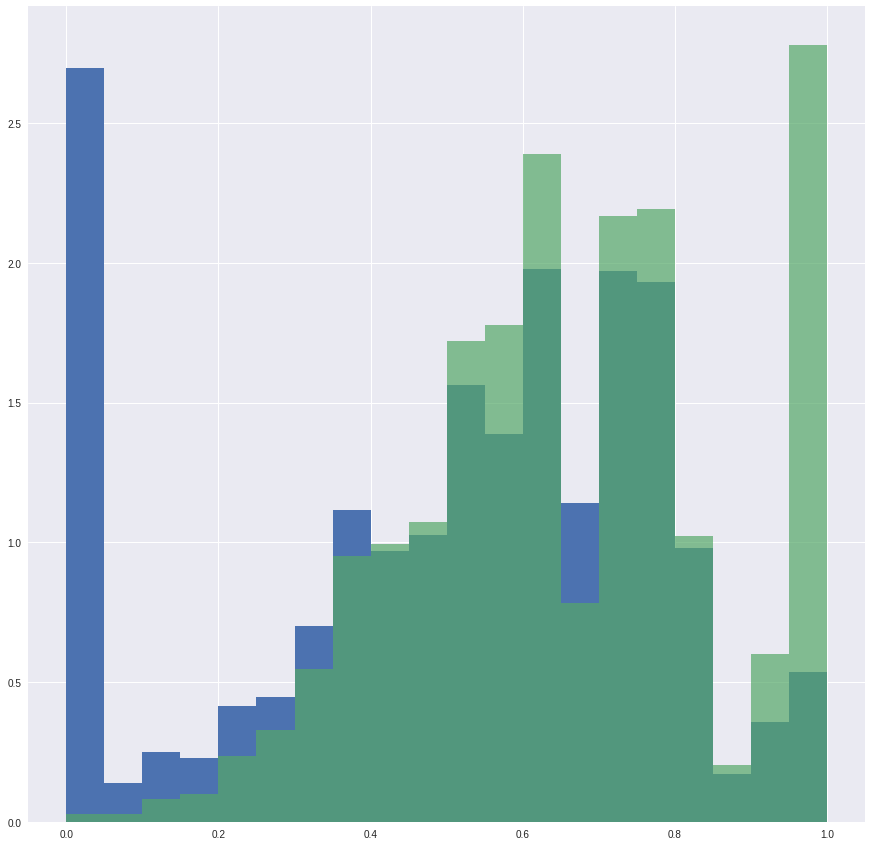

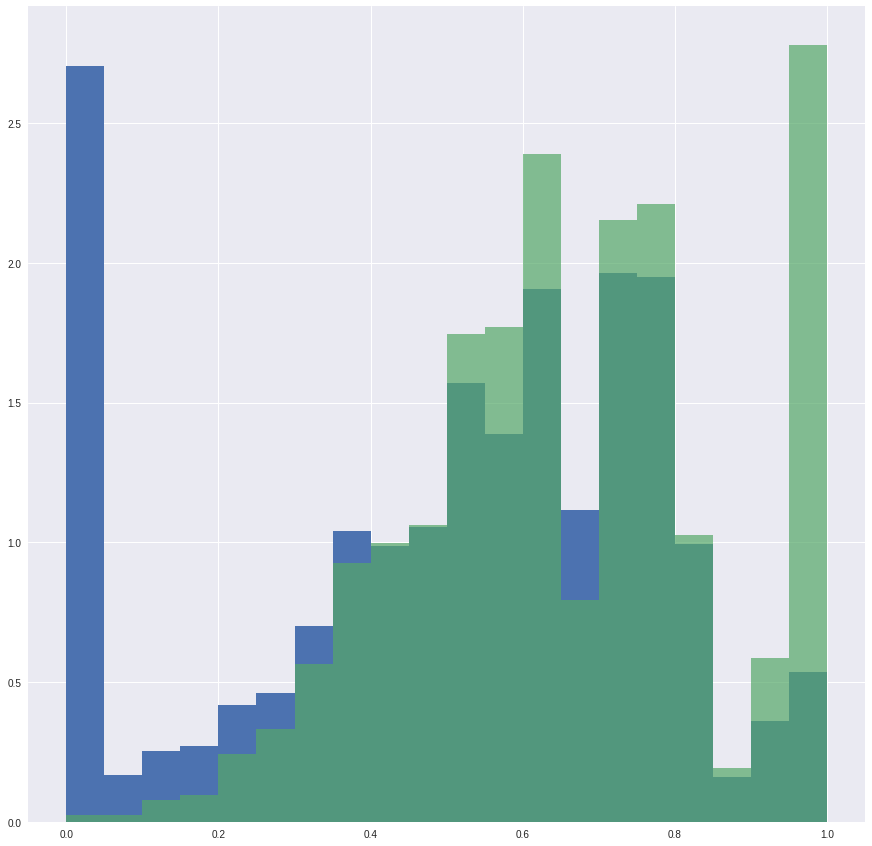

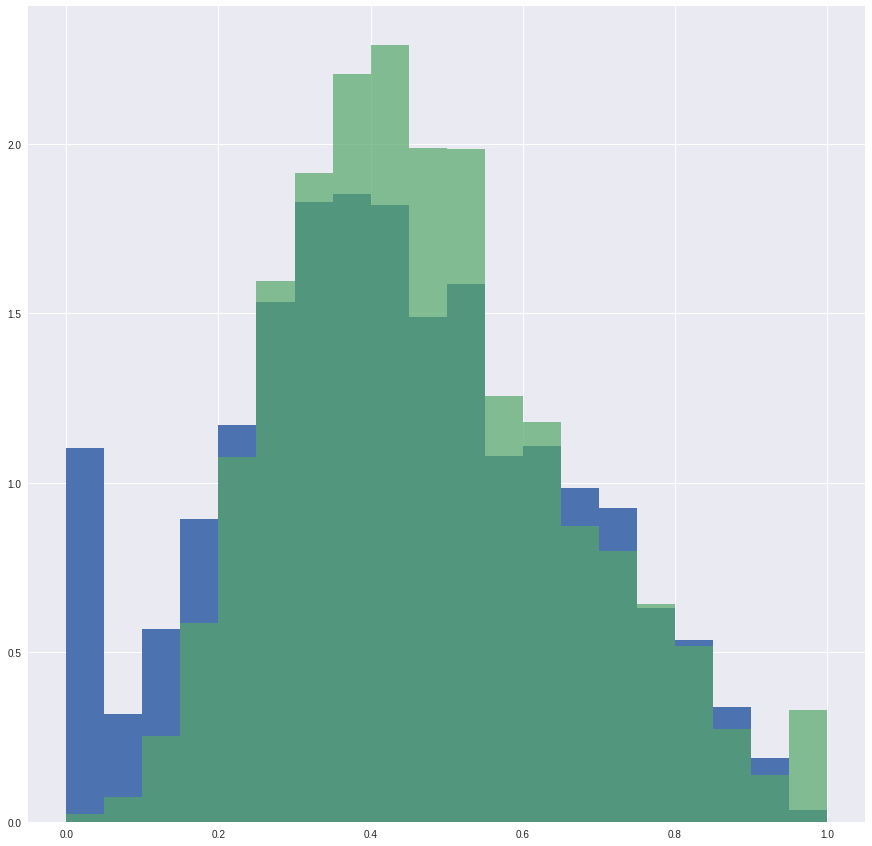

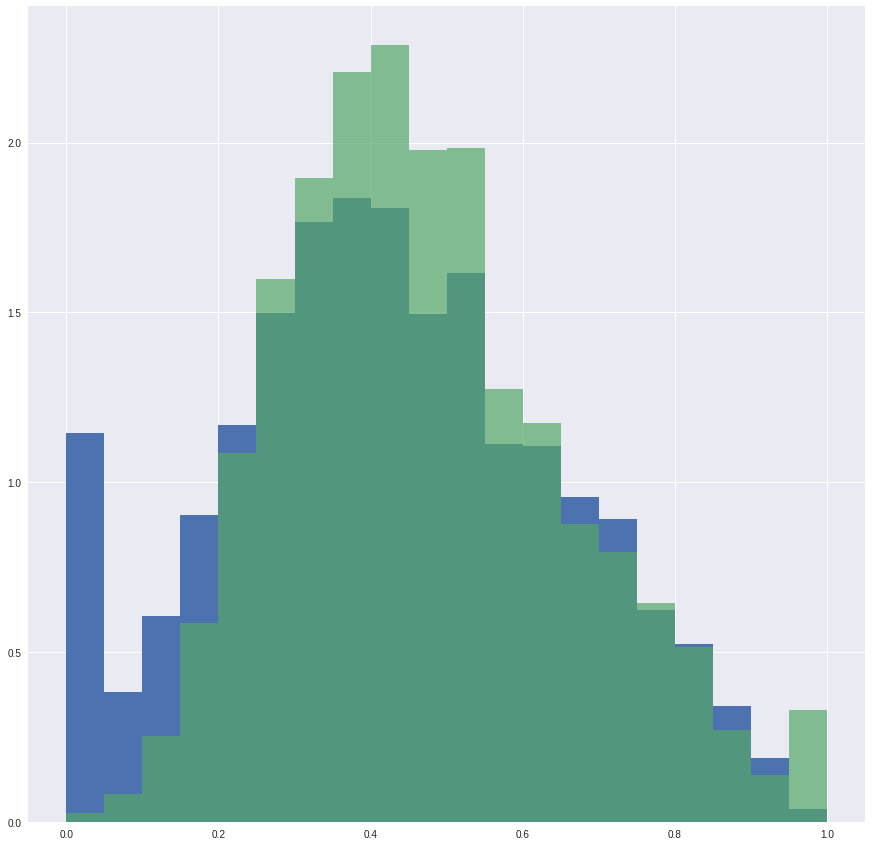

In [12]:
for feature in features_to_save:
    plt.hist(train[feature][train.is_duplicate == 0], bins=20, normed=True, label='0')
    plt.hist(train[feature][train.is_duplicate == 1], bins=20, normed=True, label='1', alpha=0.7)
    plt.show()

In [13]:
import util
util.save_feature(train, 'train', features_to_save, 'id')
util.save_feature(test, 'test', features_to_save, 'test_id')